# **Library installation and import**

In [ ]:
#install required libraries
!pip install google-api-python-client
!python -c "from oauth2client import crypt"
!pip install pyCrypto
!pip install earthengine-api
!pip install geopandas
!pip install contextily
!pip install geemap

In [ ]:
#authenticate for google sdk and google earth engine
from google.colab import auth
auth.authenticate_user()
!earthengine authenticate
import ee
ee.Initialize()

In [ ]:
#import required libraries
import urllib
import folium
from folium import plugins
import geopandas as gpd
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
import json
import pandas as pd
import altair as alt
import contextily as ctx
import xyzservices.providers as xyz
import geemap

# **Define function used for processing**

In [ ]:
# Function to remove cloud and snow pixels from Sentinel-2 SR image
def maskCloudAndShadowsSR(image):
    cloudProb = image.select('MSK_CLDPRB')
    snowProb = image.select('MSK_SNWPRB')
    cloud = cloudProb.lt(5)
    snow = snowProb.lt(5)
    scl = image.select('SCL')
    shadow = scl.eq(3) # 3 = cloud shadow
    cirrus = scl.eq(10) # 10 = cirrus
# Cloud probability less than 5% or cloud shadow classification
    mask = (cloud.And(snow)).And(cirrus.neq(1)).And(shadow.neq(1))
    return image.updateMask(mask)

# Write a function for Cloud masking
def maskS2clouds(image):
    qa = image.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
             qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).copyProperties(image, ["system:time_start"])

# Scale to Kelvin and convert to Celsius, set image acquisition time.
def convertCelsius(img):
    return img.multiply(0.02).subtract(273.15).copyProperties(img, ['system:time_start']);

# Function to clip sentinel-2 ndvi data and add color palette for visualization
def clippedndvi(image):
    return image.visualize(min=-0.3, max=1, palette=['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301']).clip(multipolygoncombined.bounds())

# Function to clip sentinel-2 ndwi data and add color palette for visualization
def clippedndwi(image):
    return image.visualize(min=-0.3, max=1, palette= ['00FFFF', '0000FF']).clip(multipolygoncombined.bounds())

# Function to create ndvi from sentinel-2 data
def addNDVI(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('ndvi')
    return image.addBands([ndvi])

# Function to create ndwi from sentinel-2 data
def addNDWI(image):
    ndwi = image.normalizedDifference(['B8', 'B12']).rename('ndwi')
      return image.addBands([ndwi])

# Function to calculate mean value for zonal statistics
def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.mean(),
                                  scale=10,
                                  crs='EPSG:3857',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
    def reduce_region_function(img):
    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)
    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
    prop_names = fc.first().propertyNames()
    prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')
    return ee.Dictionary.fromLists(prop_names, prop_lists)

# function to add date to dataframe
def add_date_info(df):
    df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
    df['Year'] = pd.DatetimeIndex(df['Timestamp']).year
    df['Month'] = pd.DatetimeIndex(df['Timestamp']).month
    df['Day'] = pd.DatetimeIndex(df['Timestamp']).day
    df['DOY'] = pd.DatetimeIndex(df['Timestamp']).dayofyear
    return df

# Function to convert image collection zonal stats value to dataframe
def collection_to_df(region_geom,geom_name,scale,epsg,s2images_prod,prod_type):
    reduce_prod = create_reduce_region_function(geometry=region_geom, reducer=ee.Reducer.mean(), scale=scale, crs=f'EPSG:{epsg}')
    prod_stat_fc = ee.FeatureCollection(s2images_prod.select(prod_type).map(reduce_prod))
    prod_dict = fc_to_dict(prod_stat_fc).getInfo()
    prod_df = pd.DataFrame(prod_dict)
    prod_df = add_date_info(prod_df)
    prod_df['Name'] = geom_name
    return prod_df

# function to plot graph of mean values extracted from image collection
def plotGraph(chart_df,field='Name',xaxis='Timestamp:T',yaxis='ndwi:Q',color='Name:O',title_='NDWI'):
    highlight = alt.selection(
    type='single', on='mouseover', fields=[], nearest=True)

    base = alt.Chart(chart_df).encode(
      x=alt.X(xaxis),
      y=alt.Y(yaxis),
      color=alt.Color(color, scale=alt.Scale(scheme='magma')))

    points = base.mark_circle().encode(
      opacity=alt.value(0),
      tooltip=[
          alt.Tooltip(color, title='Name'),
          alt.Tooltip(xaxis, title='DOY'),
          alt.Tooltip(yaxis, title=title_)
      ]).add_selection(highlight)

    lines = base.mark_line().encode(
      size=alt.condition(~highlight, alt.value(1), alt.value(3)))

    return (points + lines).properties(width=600, height=350).interactive()

# **Read KML as extract AOI**

  Name  ...      area
0  K15  ...  2.284113
1  K26  ...  3.831595

[2 rows x 4 columns]


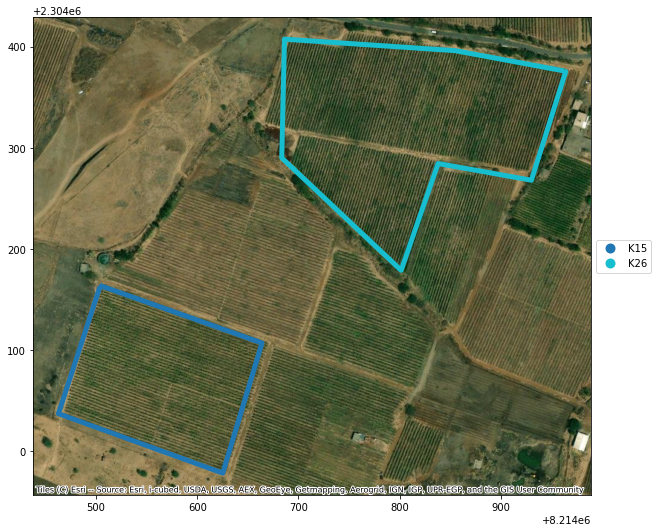

In [ ]:
# read both kml files for plots
gdf = gpd.read_file('/content/k15.kml')
gdf2 = gpd.read_file('/content/k26.kml')

# combine both geometry to one geodataframe
gdf3 = gpd.pd.concat([gdf,gdf2]) 
gdf3 = gdf3.reset_index().drop(columns=['index'])

# add name to geometries
gdf3.at[0,'Name'] = 'K15'
gdf3.at[1,'Name'] = 'K26'

# convert geometries to json to extract coordinates
diss_geom = json.loads(gdf3.dissolve().to_json())['features'][0]['geometry']['coordinates']

# manually defined and cleaned coordinate by removing z values
geom_without_z15 = [[[73.79213947802782, 20.262587453557963], [73.7935818359256, 20.262107798141976], [73.79323314875364, 20.26102455776828], [73.79177536815405, 20.261519313964016], [73.7921455129981, 20.262581477532386], [73.79213947802782, 20.262587453557963]]]
geom_without_z26 = [[[73.79626169800758, 20.264373016787196], [73.79529643803835, 20.264541601579403], [73.79378132522106, 20.26463721675329], [73.79375718533993, 20.263648980765304], [73.79481665790081, 20.262712950041806], [73.79514455795287, 20.263601801932502], [73.7959723547101, 20.26346309608096], [73.79627712070942, 20.26436672630634], [73.79626169800758, 20.264373016787196]]]
geom_without_combined = [[[[73.79213947802782, 20.262587453557963], [73.7935818359256, 20.262107798141976], [73.79323314875364, 20.26102455776828], [73.79177536815405, 20.261519313964016], [73.7921455129981, 20.262581477532386], [73.79213947802782, 20.262587453557963]]],[[[73.79626169800758, 20.264373016787196], [73.79529643803835, 20.264541601579403], [73.79378132522106, 20.26463721675329], [73.79375718533993, 20.263648980765304], [73.79481665790081, 20.262712950041806], [73.79514455795287, 20.263601801932502], [73.7959723547101, 20.26346309608096], [73.79627712070942, 20.26436672630634], [73.79626169800758, 20.264373016787196]]]] 

# converted list of coordinates to ee.Geometry
multipolygon15 = ee.Geometry.MultiPolygon(geom_without_z15)
multipolygon26 = ee.Geometry.MultiPolygon(geom_without_z26)
multipolygoncombined = ee.Geometry.MultiPolygon(geom_without_combined)

# change projected to calculate area in hectare and display it on map
gdf3 = gdf3.to_crs(epsg=3857)
gdf3["area"] = gdf3['geometry'].area/ 10**4

# display plot geometries on map
ax = gdf3.plot(column='Name',facecolor='none',edgecolor='yellow',linewidth = 5,figsize=(10,10),legend=True,legend_kwds={'loc':'center left','bbox_to_anchor':(1,0.5)})
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

# **Data Processing**

In [ ]:
# get sentinel2 data for area of interest and given time range
s2images = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(multipolygon15).filterDate('2019-09-20','2020-03-25')
s2images_cloudless = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(multipolygon15).filterDate('2019-09-20','2020-03-25').map(maskS2clouds)

# calculate ndvi and ndwi and add it to the image collection
s2images_ndvi = s2images.map(addNDVI)
s2images_ndwi = s2images.map(addNDWI)

# get modis temperature data and chirps rainfall data for comparison
modis_temp = ee.ImageCollection('MODIS/006/MOD11A2').filterBounds(multipolygoncombined).filterDate('2019-09-20','2020-03-25').select('LST_Day_1km').map(convertCelsius)
chirps_rainfall = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').filterBounds(multipolygon15).filterDate('2019-09-20','2020-03-25').select('precipitation')

In [ ]:
# Convert all the image collection of ndvi and ndwi and create dataframe by calculating mean zonal statistics 
ndvi_df15 = collection_to_df(multipolygon15,'K15',10,'32643',s2images_ndvi,'ndvi') # 10 denotes 10metres
ndvi_df26 = collection_to_df(multipolygon26,'K26',10,'32643',s2images_ndvi,'ndvi') # 10 denotes 10metres
ndvi_df = pd.concat([ndvi_df15,ndvi_df26]) # merge both plot data

ndwi_df15 = collection_to_df(multipolygon15,'K15',10,'32643',s2images_ndwi,'ndwi') # 10 denotes 10metres
ndwi_df26 = collection_to_df(multipolygon26,'K26',10,'32643',s2images_ndwi,'ndwi') # 10 denotes 10metres
ndwi_df = pd.concat([ndwi_df15,ndwi_df26]) # merge both plot data

In [ ]:
# Define GIF visualization parameters.
gifParams = {
  'region': multipolygoncombined.bounds(),
  'dimensions': 350,
  'crs': 'EPSG:3857',
  'framesPerSecond': 1,
}
# Create RGB visualization images for use as animation frames.
rgbVis_ndvi = s2images_cloudless.map(addNDVI).select('ndvi').map(clippedndvi)
rgbVis_ndwi = s2images_cloudless.map(addNDWI).select('ndwi').map(clippedndwi)

# download timeseries gif of ndvi and ndwi and add date text to it.
geemap.download_ee_video(rgbVis_ndvi, gifParams, '/content/ndvi_timeseries.gif')
text = ndvi_df15.Timestamp.tolist()
str_list = [t.strftime("%Y-%m-%d %H:%M:%S") for t in text]
geemap.add_text_to_gif('/content/ndvi_timeseries.gif', '/content/ndvi_timeseries.gif', xy=('3%', '5%'),duration=500, text_sequence=str_list, font_size=20, font_color='#ffffff')
geemap.show_image('/content/ndvi_timeseries.gif')
geemap.download_ee_video(rgbVis_ndwi, gifParams, '/content/ndwi_timeseries.gif')
text = ndwi_df15.Timestamp.tolist()
str_list = [t.strftime("%Y-%m-%d %H:%M:%S") for t in text]
geemap.add_text_to_gif('/content/ndwi_timeseries.gif', '/content/ndwi_timeseries.gif', xy=('3%', '5%'),duration=500, text_sequence=str_list, font_size=20, font_color='#ffffff')
geemap.show_image('/content/ndwi_timeseries.gif')

Generating URL...
Please wait ...
The GIF image has been saved to: /content/ndvi_timeseries.gif


Output()

Generating URL...
Please wait ...
The GIF image has been saved to: /content/ndwi_timeseries.gif


Output()

# **Visualization**

In [ ]:
# plot ndvi timeseries line chart with altair visualization python library
plotGraph(ndvi_df,field='Name',xaxis='Timestamp:T',yaxis='ndvi:Q',color='Name:O',title_='NDVI')

alt.LayerChart(...)

In [ ]:
# plot ndwi timeseries line chart with altair visualization python library
plotGraph(ndwi_df,field='Name',xaxis='Timestamp:T',yaxis='ndwi:Q',color='Name:O',title_='NDWI')

alt.LayerChart(...)

In [ ]:
# Convert all the image collection of MODIS LST data and create dataframe by calculating mean zonal statistics  
temp15 = collection_to_df(multipolygon15,'K15',1000,'32643',modis_temp,'LST_Day_1km') # 1000 denotes 1km
temp26 = collection_to_df(multipolygon26,'K26',1000,'32643',modis_temp,'LST_Day_1km') # 1000 denotes 1km
temp_combined = pd.concat([temp15,temp26])

# plot temperature timeseries line chart with altair visualization python library
plotGraph(temp_combined,field='Name',xaxis='Timestamp:T',yaxis='LST_Day_1km:Q',color='Name:O',title_='Temperature(°C)')

alt.LayerChart(...)

In [ ]:
# Convert all the image collection of Chirps rainfall and create dataframe by calculating mean zonal statistics  
rainfall15 = collection_to_df(multipolygon15,'K15',5000,'32643',chirps_rainfall,'precipitation') # 5000 denotes 5km
rainfall26 = collection_to_df(multipolygon26,'K26',5000,'32643',chirps_rainfall,'precipitation') # 5000 denotes 5km
rainfall_combined = pd.concat([rainfall15,rainfall26])

# plot rainfall timeseries line chart with altair visualization python library
plotGraph(rainfall_combined,field='Name',xaxis='Timestamp:T',yaxis='precipitation:Q',color='Name:O',title_='Precipitation(mm)')

alt.LayerChart(...)